# For One-Dimensional BS

### Question 1  
$AW_1$ or $AW_2^2$? For the Gaussian case, it is clear that we have access to a closed-form expression only for $AW_2^2$. But here, since we do not have such a formula, does it make more sense to consider $AW_1$ instead?  
I feel like it is a more relevant metric.

**Issue:**  
A small distance (close to 0, around 0.258) means we need to be very accurate.

In [1]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up module paths (adjust as needed)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (including the markovian solvers)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *

from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

In [2]:
def bs_simulation(n_sample, T, mu, sigma, dt, seed):
    np.random.seed(seed)
    # Initialize: (T+1, n_sample)
    X = np.zeros((T+1, n_sample))
    X[0, :] = 100.0  # initial condition (for us it is good deterministic first step no need to add "0" at time step 0)
    for t in range(1, T+1):
        Z = np.random.normal(size=n_sample)
        X[t, :] = X[t-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z) #exponential brownian motion
    return X

    

## To Check

What I’m doing is, as you suggested: option simulations over 30 days with a daily time step, comparing a low-volatility asset to a high-volatility one.

In [3]:
# Option simulation settings for a 1-month option (30 days)
T = 30             # 30 time steps (days)
dt = 1 / 365       # each time step represents one day (annualized time)

# Parameters for process X (safe asset, low volatility)
mu1 = 0.05         # annual drift of 5%
sigma1 = 0.15      # annual volatility of 15%

# Parameters for process Y (volatile asset, high volatility)
mu2 = 0.12         # annual drift of 12%
sigma2 = 0.50      # annual volatility of 50%

## Optimal Grid Size

How do I find the optimal grid size?

1. **Set a maximum number of sample paths**, say 150000.  
2. **Start with a relatively coarse grid**, e.g., grid size = 0.1.  
   - If you observe fast and smooth convergence, it means the number of paths is sufficient for that resolution.
3. **Gradually decrease the grid size** to improve accuracy.  
   - Repeat until convergence no deteriorate.
   - This indicates that the grid is too fine for your current number of sample paths.
4. **Choose the smallest grid size that still gives you convergence** — this ensures the most precise result for your "computational budget".

## Plot to understand what is going on

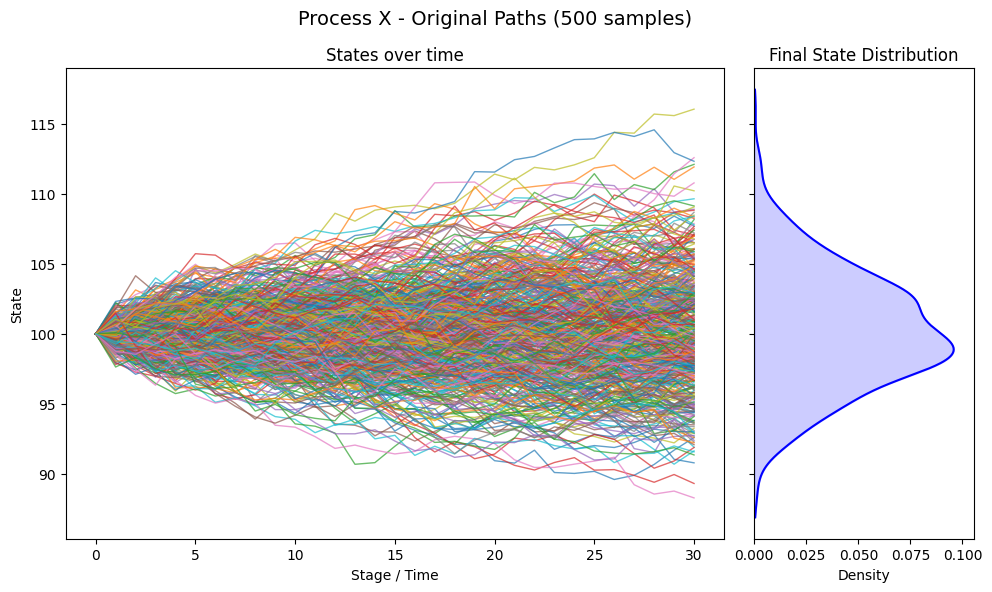

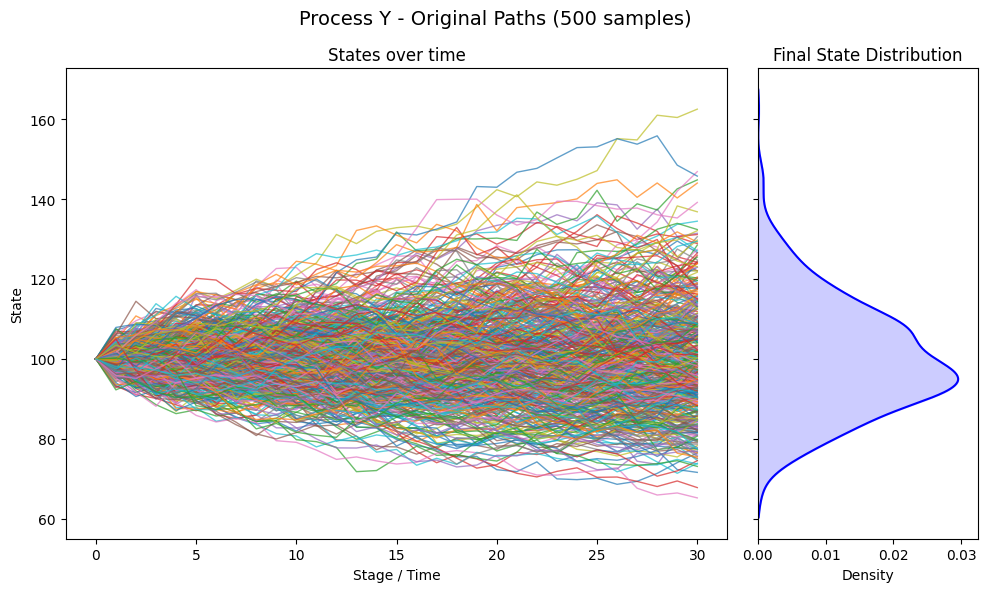

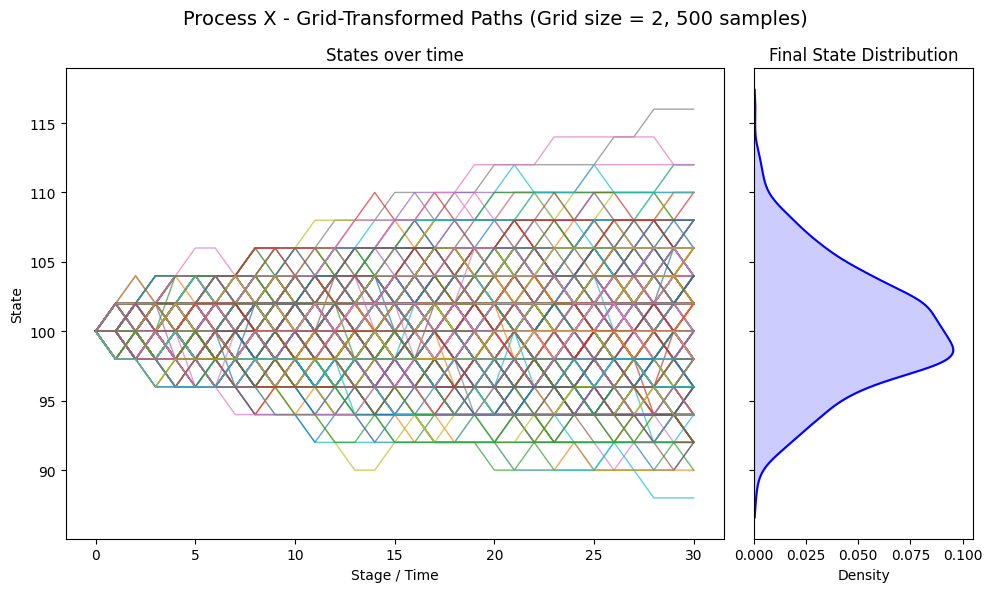

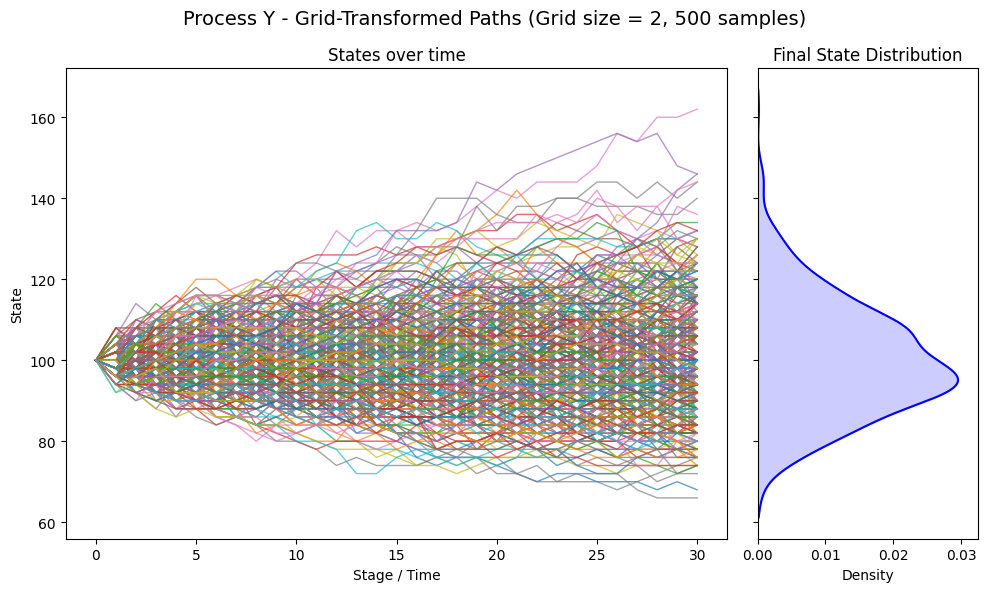

In [8]:
n_sample = 500
seed = 44

X = bs_simulation(n_sample, T, mu1, sigma1, dt, seed)
Y = bs_simulation(n_sample, T, mu2, sigma2, dt, seed)

iid_weights = np.full(n_sample, 1 / n_sample)

root = build_tree_from_paths(X.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process X - Original Paths (500 samples)",
)

root = build_tree_from_paths(Y.T, iid_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process Y - Original Paths (500 samples)",
)

fixed_grid = 0.4
fixed_grid_plot = 2

new_sample_paths, new_weights = uniform_empirical_grid_measure(X.T, fixed_grid_plot, use_weights=True) # Grid with number of grid points as in papers [0,1] divided into: 1/N^r with R=1/(T+1).
root = build_tree_from_paths(new_sample_paths, new_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process X - Grid-Transformed Paths (Grid size = 2, 500 samples)",
)

new_sample_paths, new_weights = uniform_empirical_grid_measure(Y.T, fixed_grid_plot, use_weights=True) # Grid with number of grid points as in papers [0,1] divided into: 1/N^r with R=1/(T+1).
root = build_tree_from_paths(new_sample_paths, new_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="Process Y - Grid-Transformed Paths (Grid size = 2, 500 samples)",
)

In [9]:



sample_sizes = [30000, 50000, 100000, 200000, 400000, 700000, 1000000] # <- Computational budget I was talking about before 
n_runs = 10

# Running experiments:

Here we see that increasing number of sample path as almost no impact on time -> means that most of computational time is for generating parallel task the solving them is super fast -> can go to 100'000 sample easily scaling in time step will however slow down a lot as for each time step set up parallel process which takes time (around 0.25 second per time step)

In [10]:
results = {}

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two independent seeds
        seed = np.random.randint(10000)
        
        # Simulate the BS processes
        X = bs_simulation(n_sample, T, mu1, sigma1, dt, seed)
        Y = bs_simulation(n_sample, T, mu2, sigma2, dt, seed)
        
        # Convert to adapted paths using grid quantization (the function path2adaptedpath is assumed available)
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional measures (markovian)
        mu_x = qpath2mu_x(qX, markovian=True)
        nu_y = qpath2mu_x(qY, markovian=True)
        
        # Updated list representations now return 7 items:
        (mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x, q2v)
        (nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y, q2v)
        
        # Compute adapted Wasserstein squared distance using the updated parallel solver
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_markovian(mu_x_cn, mu_x_v, mu_x_w, mu_x_idx,
                                                nu_y_cn, nu_y_v, nu_y_w, nu_y_idx,
                                                n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f}s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs}


Running experiments for sample size: 30000
Run 1: AW_2^2 = 1640.5461, Time = 14.0012s
Run 2: AW_2^2 = 1640.5949, Time = 13.9350s
Run 3: AW_2^2 = 1641.2338, Time = 14.5929s
Run 4: AW_2^2 = 1653.9363, Time = 15.2693s
Run 5: AW_2^2 = 1639.4507, Time = 14.7725s
Run 6: AW_2^2 = 1639.0023, Time = 15.1855s
Run 7: AW_2^2 = 1636.3889, Time = 14.6252s
Run 8: AW_2^2 = 1635.6683, Time = 14.7317s
Run 9: AW_2^2 = 1656.4652, Time = 14.7001s
Run 10: AW_2^2 = 1648.1652, Time = 14.7634s

Running experiments for sample size: 50000
Run 1: AW_2^2 = 1647.9530, Time = 15.3048s
Run 2: AW_2^2 = 1645.8824, Time = 15.4798s
Run 3: AW_2^2 = 1637.5099, Time = 15.4335s
Run 4: AW_2^2 = 1654.2195, Time = 14.3242s
Run 5: AW_2^2 = 1641.6289, Time = 15.2889s
Run 6: AW_2^2 = 1635.8016, Time = 15.2926s
Run 7: AW_2^2 = 1650.4605, Time = 16.7569s
Run 8: AW_2^2 = 1631.5549, Time = 18.8673s
Run 9: AW_2^2 = 1630.6167, Time = 19.2697s
Run 10: AW_2^2 = 1619.0818, Time = 14.8304s

Running experiments for sample size: 100000
Run 1

In [12]:
sample_sizes = [1300000]

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two independent seeds
        seed = np.random.randint(10000)
        
        # Simulate the BS processes
        X = bs_simulation(n_sample, T, mu1, sigma1, dt, seed)
        Y = bs_simulation(n_sample, T, mu2, sigma2, dt, seed)
        
        # Convert to adapted paths using grid quantization (the function path2adaptedpath is assumed available)
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional measures (markovian)
        mu_x = qpath2mu_x(qX, markovian=True)
        nu_y = qpath2mu_x(qY, markovian=True)
        
        # Updated list representations now return 7 items:
        (mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x, q2v)
        (nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y, q2v)
        
        # Compute adapted Wasserstein squared distance using the updated parallel solver
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_markovian(mu_x_cn, mu_x_v, mu_x_w, mu_x_idx,
                                                nu_y_cn, nu_y_v, nu_y_w, nu_y_idx,
                                                n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f}s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs}


Running experiments for sample size: 1300000
Run 1: AW_2^2 = 1629.7857, Time = 19.0819s
Run 2: AW_2^2 = 1633.9545, Time = 19.0914s
Run 3: AW_2^2 = 1632.2669, Time = 18.9216s
Run 4: AW_2^2 = 1629.2067, Time = 18.6500s
Run 5: AW_2^2 = 1631.4422, Time = 17.8701s
Run 6: AW_2^2 = 1632.9390, Time = 19.0937s
Run 7: AW_2^2 = 1627.9291, Time = 19.7791s
Run 8: AW_2^2 = 1629.9828, Time = 17.9385s
Run 9: AW_2^2 = 1631.8680, Time = 18.4775s
Run 10: AW_2^2 = 1633.5720, Time = 18.9388s


# Ploting convergence:

With this grid size we get nice convergence

Sample Size: 30000
  Mean AW_2^2: 1643.1452 ± 6.8436
  Mean Time: 14.6577s ± 0.4053s

Sample Size: 50000
  Mean AW_2^2: 1639.4709 ± 10.1493
  Mean Time: 16.0848s ± 1.6022s

Sample Size: 100000
  Mean AW_2^2: 1633.7792 ± 3.7850
  Mean Time: 16.2755s ± 1.0566s

Sample Size: 200000
  Mean AW_2^2: 1631.8684 ± 7.1218
  Mean Time: 16.6876s ± 0.3464s

Sample Size: 400000
  Mean AW_2^2: 1630.8680 ± 2.6935
  Mean Time: 17.1855s ± 0.2952s

Sample Size: 700000
  Mean AW_2^2: 1631.7751 ± 2.3430
  Mean Time: 17.9787s ± 0.3837s

Sample Size: 1000000
  Mean AW_2^2: 1632.2159 ± 2.8389
  Mean Time: 17.8996s ± 0.3818s

Sample Size: 1300000
  Mean AW_2^2: 1631.2947 ± 1.8959
  Mean Time: 18.7843s ± 0.5454s



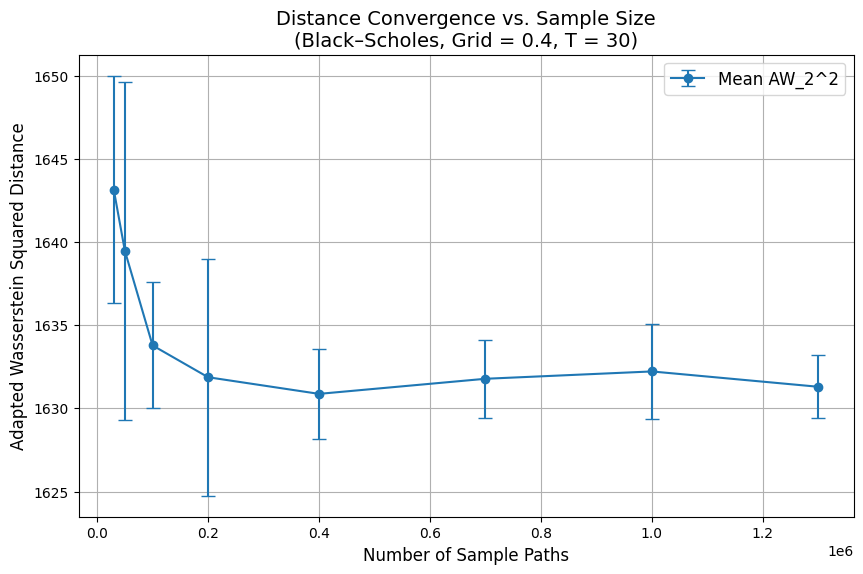

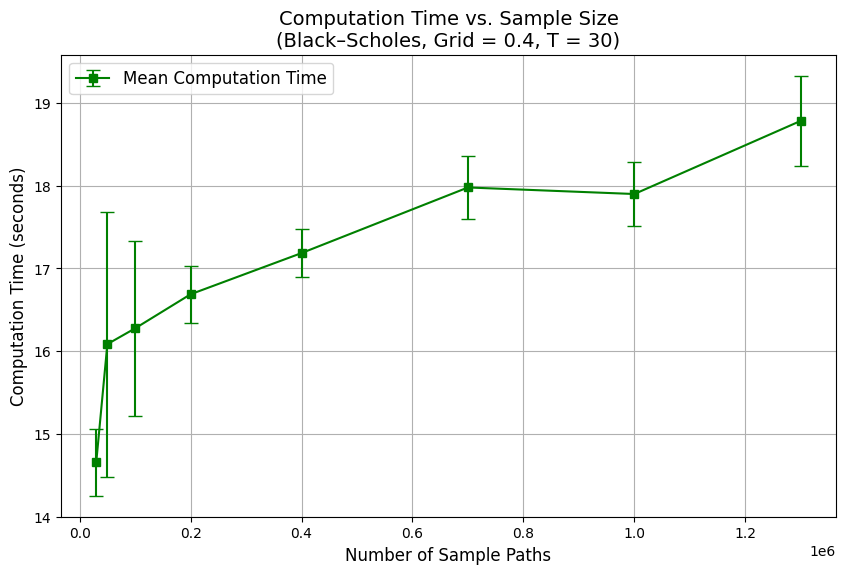

In [14]:
aggregated = {}
for n_sample in sorted(results.keys()):
    dists = results[n_sample]["distances"]
    times = results[n_sample]["times"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f}s ± {std_time:.4f}s\n")

samples = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in samples]
std_distances = [aggregated[n]["std_distance"] for n in samples]
mean_times = [aggregated[n]["mean_time"] for n in samples]
std_times = [aggregated[n]["std_time"] for n in samples]

# Plot 1: Adapted AW_2^2 vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Black–Scholes, Grid = 0.4, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Black–Scholes, Grid = 0.4, T = 30)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()